## Importando Bibliotecas

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
import warnings
import sys
sys.path.append(r'/home/jean/projetos/pod-bank/global/')
from util import *
warnings.filterwarnings("ignore")
random.seed(42)

/home/jean/projetos/pod-bank/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lendo os dados

In [2]:
df_treino_full = pd.read_parquet('../data/abt/abt_train', engine='fastparquet')

In [3]:
df_treino_full.shape

(215257, 552)

### Aplicando primeira feature selection

In [4]:
import pickle
with open('../artifacts/prd_first_list_features.pkl', 'rb') as f:
    colunas_finais = pickle.load(f)

In [5]:
df_treino_full = df_treino_full[colunas_finais]
df_treino_full.shape

(215257, 161)

## Split dos dados

In [6]:

from sklearn.model_selection import train_test_split


abt = df_treino_full.drop(columns=['TARGET','SK_ID_CURR'])
target = df_treino_full.TARGET

X_train, X_test, y_train, y_test = train_test_split(abt,target,test_size=0.3,random_state=0)



## Dataprep

In [607]:
import numpy as np
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

abt_treino = pd.concat((X_train,y_train),axis=1)
abt_test = pd.concat((X_test,y_test),axis=1)

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

num_features_train = X_train.select_dtypes(exclude='object')
cat_features_train = X_train.select_dtypes(include='object')

num_features_test = X_test[num_features_train.columns]
cat_features_test = X_test[cat_features_train.columns]

lista_nums = num_features_train.columns
lista_cats = cat_features_train.columns

df1 = pd.DataFrame(imputer_num.fit_transform(num_features_train),columns=lista_nums)
df2 = pd.DataFrame(imputer_num.transform(num_features_test),columns=lista_nums)
df1.index = num_features_train.index
df2.index = num_features_test.index
num_features_train = df1.copy()
num_features_test = df2.copy()

df1 = pd.DataFrame(imputer_cat.fit_transform(cat_features_train),columns=lista_cats)
df2 = pd.DataFrame(imputer_cat.transform(cat_features_test),columns=lista_cats)
df1.index = cat_features_train.index
df2.index = cat_features_test.index
cat_features_train = df1.copy()
cat_features_test = df2.copy()

ce = TargetEncoder()

cat_features_train = ce.fit_transform(cat_features_train,y_train)
cat_features_test = ce.transform(cat_features_test,y_test)

new_abt_treino = pd.concat((num_features_train,cat_features_train),axis=1)
new_abt_teste = pd.concat((num_features_test,cat_features_test),axis=1)

threshold = 0.5

# Calculate the correlation matrix
corr_matrix = new_abt_treino.corr().abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop based on the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the columns
new_abt_treino = new_abt_treino.drop(columns=to_drop)
new_abt_teste = new_abt_teste.drop(columns=to_drop)

rf_model = RandomForestClassifier(
    random_state=0,
    class_weight='balanced',       # Balanceamento automático de classes
    max_depth=3,                  # Limita a profundidade máxima de cada árvore a 5 níveis
    min_samples_split=15,          # Exige pelo menos 20 amostras para considerar uma divisão
    n_estimators=50               # Mantendo 100 árvores na floresta (parâmetro padrão)
)

rf_model.fit(new_abt_treino, y_train)

# Obtém importância das features do modelo treinado
feature_importance = rf_model.feature_importances_

df = pd.DataFrame({'Feature':new_abt_treino.columns,'Importance':feature_importance})

features_rl = df.sort_values(by='Importance',ascending=False)[:30].Feature.to_list()

In [608]:
features_rl = features_rl + ['TARGET']
features_rl

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'OCCUPATION_TYPE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'DAYS_EMPLOYED',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'NAME_EDUCATION_TYPE',
 'CODE_GENDER',
 'DAYS_LAST_PHONE_CHANGE',
 'VL_TOT_CNT_CREDIT_PROLONG_U9M_BUREAU',
 'AMT_GOODS_PRICE',
 'QT_MIN_CREDIT_DAY_OVERDUE_CRED_ACT_CLD_BUREAU',
 'VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU',
 'VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU',
 'DAYS_ID_PUBLISH',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU',
 'FLAG_DOCUMENT_3',
 'VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU',
 'VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU',
 'DAYS_REGISTRATION',
 'QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU',
 'VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU',
 'QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU',
 'QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU',
 'QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP',
 'QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU',
 'REGIO

In [609]:
#salvar lista em um arquivo .pkl
with open('../artifacts/features_reg_log.pkl', 'wb') as f:pickle.dump(features_rl, f)

In [610]:
abt_treino_01 = abt_treino[features_rl]
abt_treino_01.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,OCCUPATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,DAYS_EMPLOYED,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,...,DAYS_REGISTRATION,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU,QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP,QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU,REGION_POPULATION_RELATIVE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET
28668,0.688661,0.440058,0.229335,Laborers,-791.0,-3821,-791.0,Secondary / secondary special,M,-1953.0,...,-2441.0,-37.0,0.0,-37.0,0.0,NaN,0.0,0.009334,0.0,0
35005,0.646244,NaN,0.403597,Core staff,NaN,-587,NaN,Higher education,F,-160.0,...,-4130.0,NaN,NaN,NaN,NaN,365243.0,NaN,0.009657,0.0,0
105487,0.595644,0.495666,NaN,Sales staff,-268.0,-741,-268.0,Secondary / secondary special,F,-404.0,...,-8149.0,-7.0,0.0,-7.0,0.0,NaN,0.0,0.031329,0.0,0
84068,0.646119,0.681706,0.678269,Core staff,-1096.0,-1712,-1096.0,Higher education,F,-2092.0,...,-4823.0,-12.0,0.0,-12.0,0.0,365243.0,0.0,0.019689,2.0,0
51787,0.701218,0.591977,0.709834,None,-1269.0,365243,-1269.0,Secondary / secondary special,F,-1005.0,...,-908.0,-8.0,0.0,-129.0,0.0,NaN,0.0,0.019689,0.0,0


In [611]:
abt_test_01 = abt_test[features_rl]
abt_test_01.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,OCCUPATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,DAYS_EMPLOYED,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,...,DAYS_REGISTRATION,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU,QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP,QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU,REGION_POPULATION_RELATIVE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET
22198,0.575481,0.703203,NaN,Laborers,-2489.0,-2268,-2489.0,Secondary / secondary special,M,-1889.0,...,-3020.0,NaN,0.0,NaN,NaN,NaN,0.0,0.026392,1.0,0
133679,0.516697,0.553165,0.26864,Laborers,NaN,-1139,350.0,Secondary / secondary special,M,-351.0,...,-19.0,-14.0,NaN,NaN,NaN,365243.0,0.0,0.028663,0.0,0
106217,0.285131,NaN,NaN,Cooking staff,NaN,-2761,7033.0,Secondary / secondary special,F,-510.0,...,-1198.0,-24.0,NaN,-24.0,NaN,NaN,0.0,0.026392,0.0,0
149637,0.727543,0.773896,NaN,Cleaning staff,-2121.0,-5127,-2121.0,Secondary / secondary special,F,-1537.0,...,-7577.0,-16.0,0.0,NaN,NaN,NaN,0.0,0.006629,0.0,0
131246,0.564683,0.431192,NaN,Managers,-2495.0,-3590,-2495.0,Higher education,M,-1571.0,...,-295.0,-28.0,0.0,NaN,NaN,365243.0,0.0,0.035792,0.0,0


## Impute missing

In [612]:
abt_treino_02, means = fillna_numeric(abt_treino_01)

with open('../artifacts/prd_fillna_reg_log.pkl', 'wb') as f:
  pickle.dump(means, f)

In [613]:
with open('../artifacts/prd_fillna_reg_log.pkl', 'rb') as f:
  loaded_means = pickle.load(f)

In [614]:
abt_test_02 = fillna_num_prod(abt_test_01, loaded_means)
abt_test_02.shape

(64578, 31)

In [615]:
abt_treino_03, modes = fillna_categorical(abt_treino_02)

with open('../artifacts/prd_fillna_categorical_rl.pkl', 'wb') as f:
  pickle.dump(modes, f)

In [616]:
with open('../artifacts/prd_fillna_categorical_rl.pkl', 'rb') as f:
  loaded_modes = pickle.load(f)

In [617]:
abt_test_03 = fillna_catg_prod(abt_test_02, loaded_modes)
abt_test_03.shape

(64578, 31)

In [618]:
features_rl

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'OCCUPATION_TYPE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'DAYS_EMPLOYED',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'NAME_EDUCATION_TYPE',
 'CODE_GENDER',
 'DAYS_LAST_PHONE_CHANGE',
 'VL_TOT_CNT_CREDIT_PROLONG_U9M_BUREAU',
 'AMT_GOODS_PRICE',
 'QT_MIN_CREDIT_DAY_OVERDUE_CRED_ACT_CLD_BUREAU',
 'VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU',
 'VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU',
 'DAYS_ID_PUBLISH',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU',
 'FLAG_DOCUMENT_3',
 'VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU',
 'VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU',
 'DAYS_REGISTRATION',
 'QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU',
 'VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU',
 'QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU',
 'QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU',
 'QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP',
 'QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU',
 'REGIO

## Verificando linearidade com a Log Odds

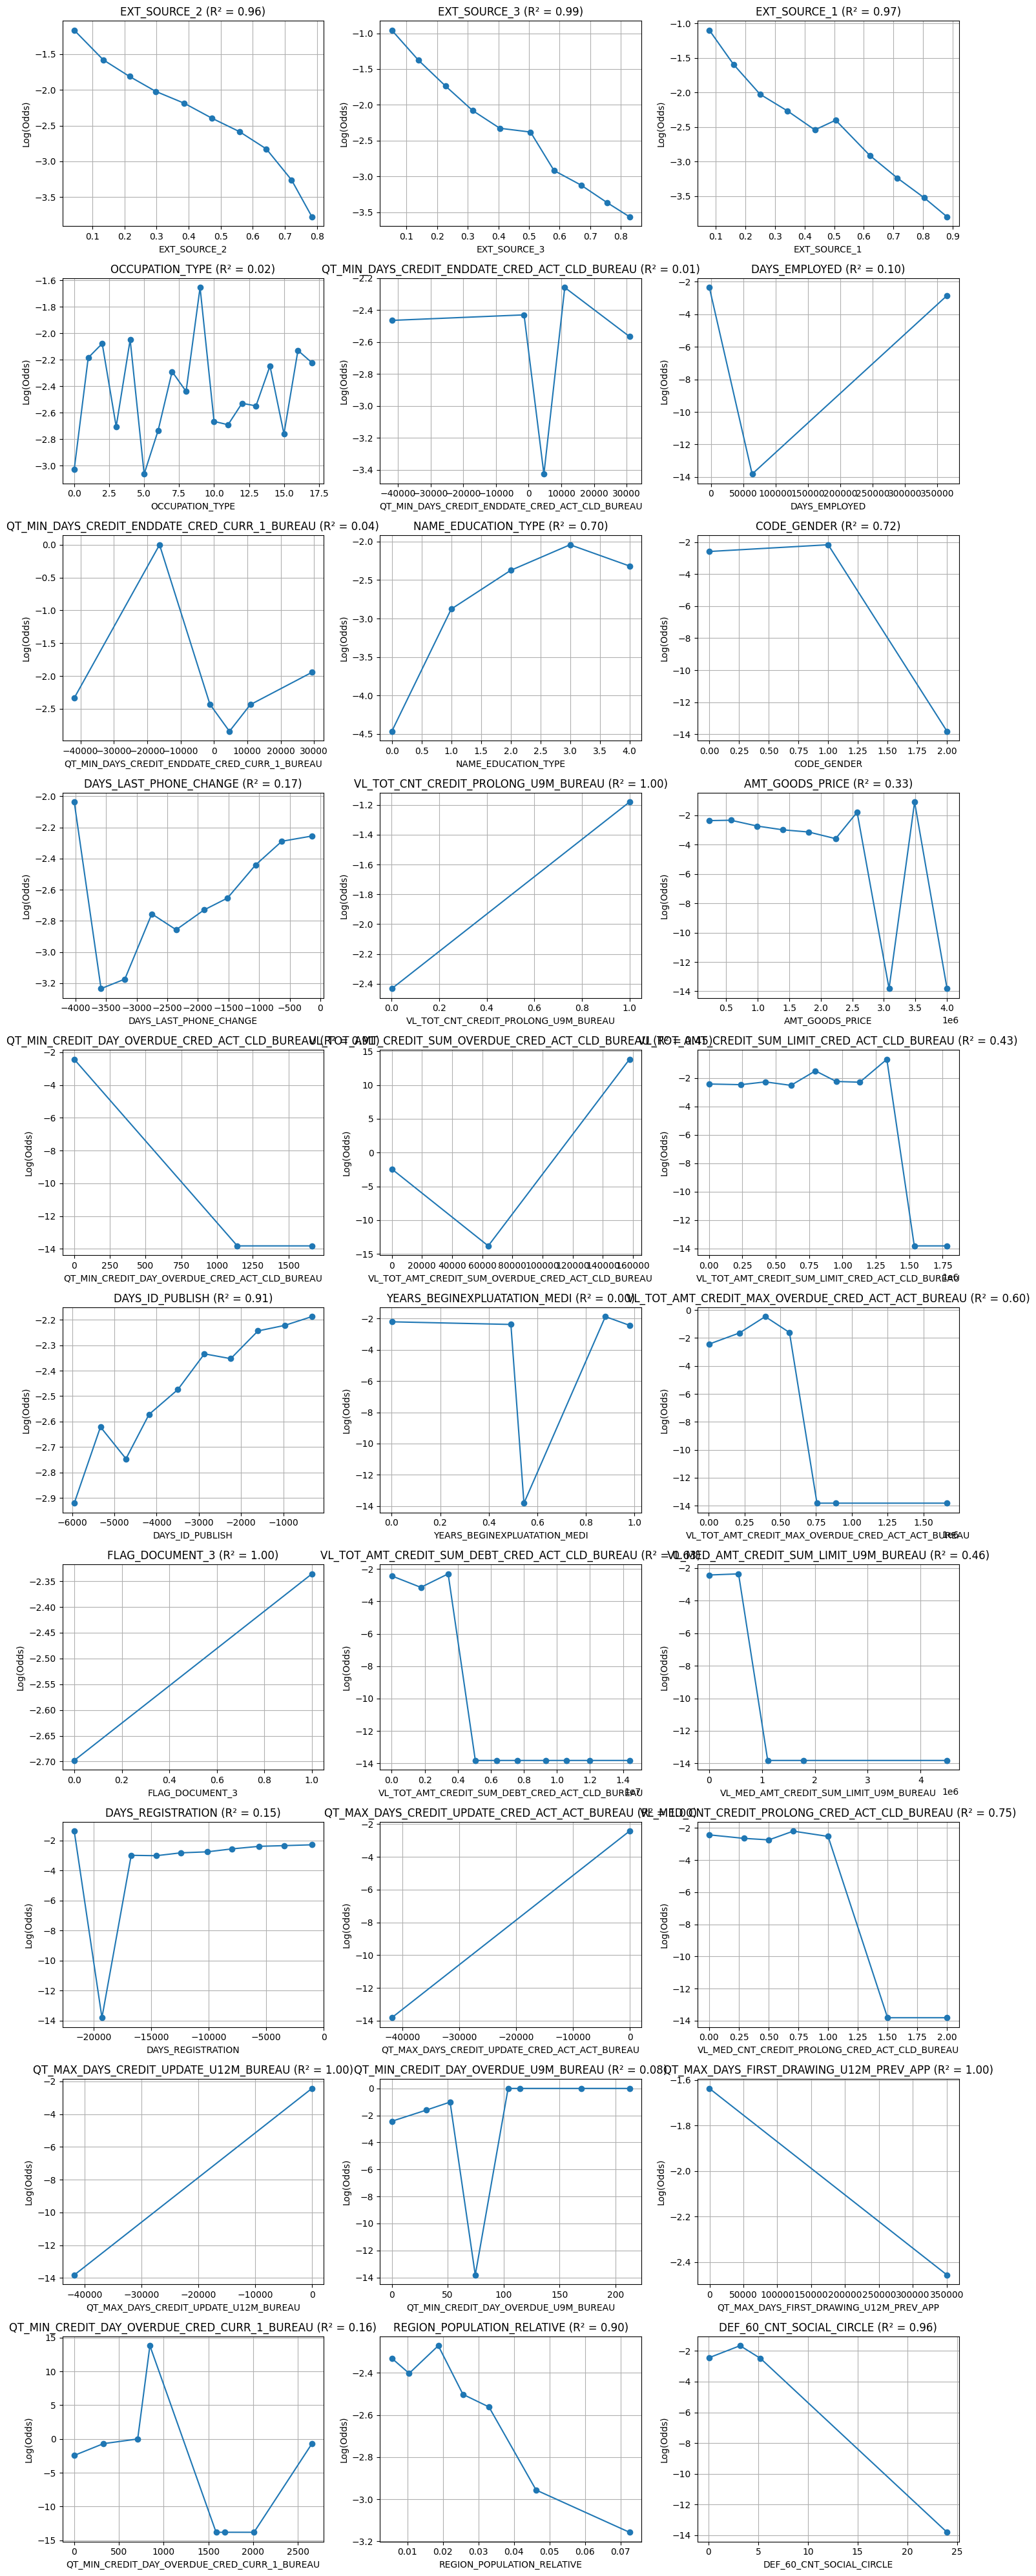

In [619]:
r2_df = calculate_r2_for_logodds_with_grid(
    abt_treino_03,
    list(abt_treino_03.drop(columns='TARGET').columns),
    target='TARGET',
    threshold=0.85,
    ncols=3
)

In [620]:
r2_df

,Variable,R^2,Feat Eng
0,EXT_SOURCE_2,0.961862,Usar como contínua
1,EXT_SOURCE_3,0.985777,Usar como contínua
2,EXT_SOURCE_1,0.973064,Usar como contínua
3,OCCUPATION_TYPE,0.021573,Categorizar
4,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,0.009743,Categorizar
5,DAYS_EMPLOYED,0.096349,Categorizar
6,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,0.040392,Categorizar
7,NAME_EDUCATION_TYPE,0.698962,Categorizar
8,CODE_GENDER,0.721989,Categorizar
9,DAYS_LAST_PHONE_CHANGE,0.171947,Categorizar


In [621]:
variaveis_continuas = r2_df[r2_df['Feat Eng'] == 'Usar como contínua']['Variable'].tolist()
categorize_vars = r2_df[r2_df['Feat Eng'] == 'Categorizar']['Variable'].tolist()

## Categorização
## Categorizar as variáveis que estão não apresentaram comportamento linear com a log da odds

In [622]:
categorize_vars

['OCCUPATION_TYPE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'DAYS_EMPLOYED',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'NAME_EDUCATION_TYPE',
 'CODE_GENDER',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_GOODS_PRICE',
 'VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU',
 'VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU',
 'VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU',
 'VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU',
 'DAYS_REGISTRATION',
 'VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU',
 'QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU',
 'QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU']

In [623]:
# Verificar cardinalidade dessas variáveis
df =  generate_metadata_v2(abt_treino_03[categorize_vars])

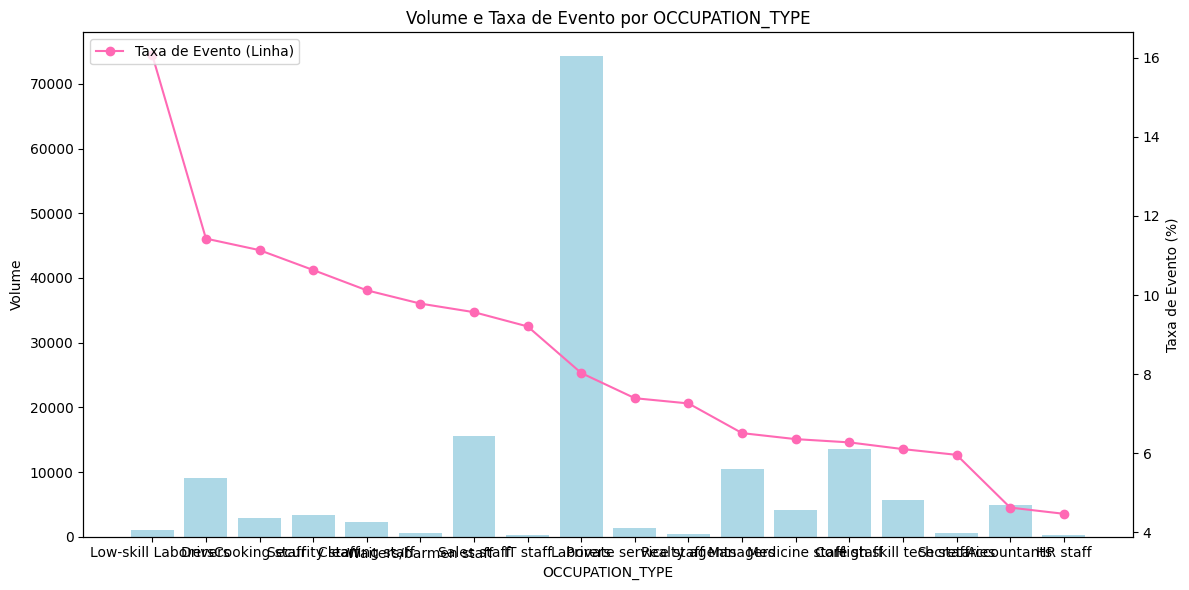

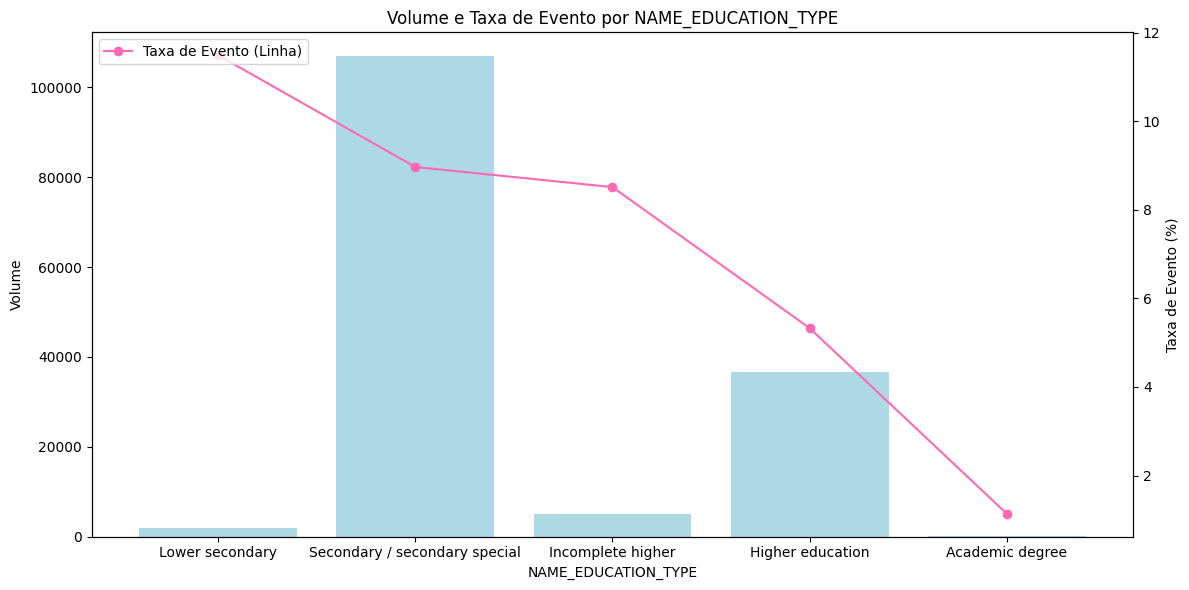

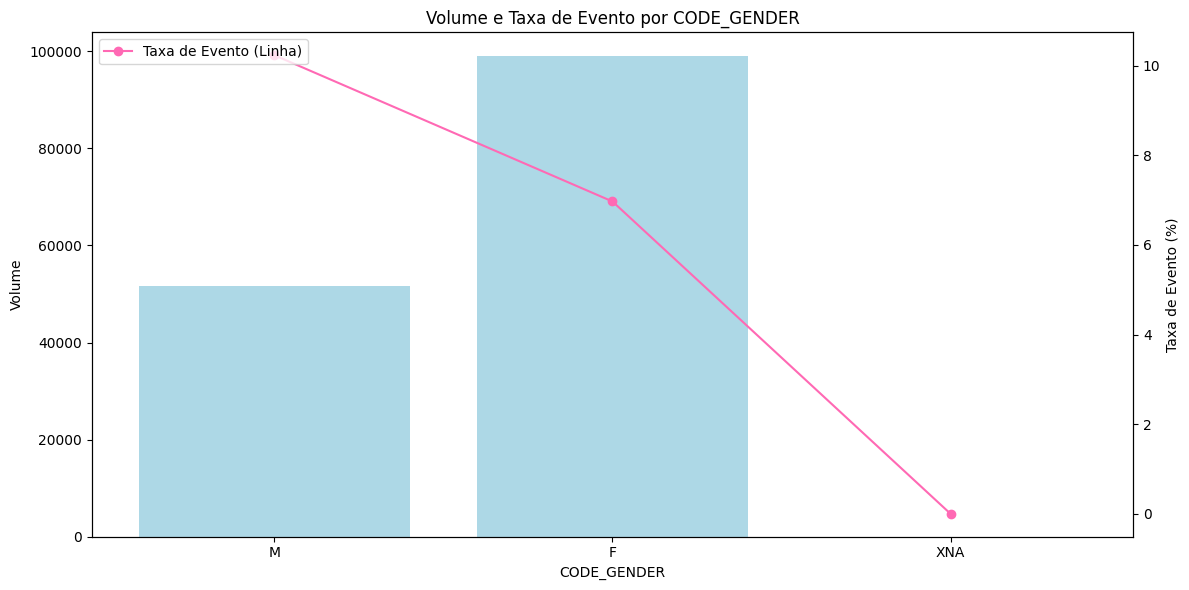

In [624]:
# Analizar essas variáveis (variaveis_categorizar) que contém baixa cardinalidade (menor ou igual a 20) e verificar se há ordenação entre as categorias
ordinais = df[df.cardinalidade <= 20].nome_variavel.to_list()
for var in ordinais:
    result = analyze_variable(abt_treino_03, var, "TARGET")

In [625]:
abt_treino_03.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,OCCUPATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,DAYS_EMPLOYED,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,...,DAYS_REGISTRATION,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU,QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP,QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU,REGION_POPULATION_RELATIVE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET
28668,0.688661,0.440058,0.229335,Laborers,-791.000000,-3821.0,-791.000000,Secondary / secondary special,M,-1953.0,...,-2441.0,-37.00000,0.000000,-37.000000,0.000000,342218.977209,0.000000,0.009334,0.0,0
35005,0.646244,0.511483,0.403597,Core staff,-1356.180463,-587.0,-1031.528897,Higher education,F,-160.0,...,-4130.0,-61.10535,0.004254,-30.660983,0.071462,365243.000000,0.174496,0.009657,0.0,0
105487,0.595644,0.495666,0.502544,Sales staff,-268.000000,-741.0,-268.000000,Secondary / secondary special,F,-404.0,...,-8149.0,-7.00000,0.000000,-7.000000,0.000000,342218.977209,0.000000,0.031329,0.0,0
84068,0.646119,0.681706,0.678269,Core staff,-1096.000000,-1712.0,-1096.000000,Higher education,F,-2092.0,...,-4823.0,-12.00000,0.000000,-12.000000,0.000000,365243.000000,0.000000,0.019689,2.0,0
51787,0.701218,0.591977,0.709834,Laborers,-1269.000000,365243.0,-1269.000000,Secondary / secondary special,F,-1005.0,...,-908.0,-8.00000,0.000000,-129.000000,0.000000,342218.977209,0.000000,0.019689,0.0,0


In [626]:
df[df['tipo'] == 'float64']

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
1,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,float64,0,0.0,4753
2,DAYS_EMPLOYED,float64,0,0.0,10908
3,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,float64,0,0.0,5864
6,DAYS_LAST_PHONE_CHANGE,float64,0,0.0,3643
7,AMT_GOODS_PRICE,float64,0,0.0,712
8,VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU,float64,0,0.0,45
9,VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU,float64,0,0.0,1217
10,YEARS_BEGINEXPLUATATION_MEDI,float64,0,0.0,218
11,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,float64,0,0.0,12319
12,VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU,float64,0,0.0,3080


In [627]:
result = categorize_with_decision_tree(abt_treino_03, n_categories=2, target='TARGET', numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU')
df1_treino = apply_tree_bins(abt_treino_03, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU')
df1_teste = apply_tree_bins(abt_test_03, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU')

In [628]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.060881,58491,-inf,-1370.0
1,2,0.093613,92188,-1369.0,inf


In [629]:
df1_treino.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,OCCUPATION_TYPE,DAYS_EMPLOYED,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,VL_TOT_CNT_CREDIT_PROLONG_U9M_BUREAU,...,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU,QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP,QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU,REGION_POPULATION_RELATIVE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET,TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU
28668,0.688661,0.440058,0.229335,Laborers,-3821.0,-791.000000,Secondary / secondary special,M,-1953.0,0.000000,...,-37.00000,0.000000,-37.000000,0.000000,342218.977209,0.000000,0.009334,0.0,0,1
35005,0.646244,0.511483,0.403597,Core staff,-587.0,-1031.528897,Higher education,F,-160.0,0.001935,...,-61.10535,0.004254,-30.660983,0.071462,365243.000000,0.174496,0.009657,0.0,0,1
105487,0.595644,0.495666,0.502544,Sales staff,-741.0,-268.000000,Secondary / secondary special,F,-404.0,0.000000,...,-7.00000,0.000000,-7.000000,0.000000,342218.977209,0.000000,0.031329,0.0,0,1
84068,0.646119,0.681706,0.678269,Core staff,-1712.0,-1096.000000,Higher education,F,-2092.0,0.000000,...,-12.00000,0.000000,-12.000000,0.000000,365243.000000,0.000000,0.019689,2.0,0,1
51787,0.701218,0.591977,0.709834,Laborers,365243.0,-1269.000000,Secondary / secondary special,F,-1005.0,0.000000,...,-8.00000,0.000000,-129.000000,0.000000,342218.977209,0.000000,0.019689,0.0,0,1


In [630]:
result = categorize_with_decision_tree(df1_treino, n_categories=2, target='TARGET', numeric_var='DAYS_EMPLOYED')
df2_treino = apply_tree_bins(df1_treino, result, numeric_var='DAYS_EMPLOYED')
df2_teste = apply_tree_bins(df1_teste, result, numeric_var='DAYS_EMPLOYED')

In [631]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.053859,33866,-inf,-2995.0
1,2,0.088749,116813,-2994.0,inf


In [632]:
df2_treino.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,OCCUPATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,VL_TOT_CNT_CREDIT_PROLONG_U9M_BUREAU,AMT_GOODS_PRICE,...,VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU,QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP,QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU,REGION_POPULATION_RELATIVE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET,TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,TFT_DAYS_EMPLOYED
28668,0.688661,0.440058,0.229335,Laborers,-791.000000,Secondary / secondary special,M,-1953.0,0.000000,450000.0,...,0.000000,-37.000000,0.000000,342218.977209,0.000000,0.009334,0.0,0,1,0
35005,0.646244,0.511483,0.403597,Core staff,-1031.528897,Higher education,F,-160.0,0.001935,882000.0,...,0.004254,-30.660983,0.071462,365243.000000,0.174496,0.009657,0.0,0,1,1
105487,0.595644,0.495666,0.502544,Sales staff,-268.000000,Secondary / secondary special,F,-404.0,0.000000,180000.0,...,0.000000,-7.000000,0.000000,342218.977209,0.000000,0.031329,0.0,0,1,1
84068,0.646119,0.681706,0.678269,Core staff,-1096.000000,Higher education,F,-2092.0,0.000000,481500.0,...,0.000000,-12.000000,0.000000,365243.000000,0.000000,0.019689,2.0,0,1,1
51787,0.701218,0.591977,0.709834,Laborers,-1269.000000,Secondary / secondary special,F,-1005.0,0.000000,90000.0,...,0.000000,-129.000000,0.000000,342218.977209,0.000000,0.019689,0.0,0,1,1


In [633]:
result = categorize_with_decision_tree(df2_treino, n_categories=3, target='TARGET', numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU')
df3_treino = apply_tree_bins(df2_treino, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU')
df3_teste = apply_tree_bins(df2_teste, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU')

In [634]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.064061,73040,-inf,-1032.0
1,3,0.093089,53669,-1031.528897,-215.0
2,4,0.104965,23970,-214.000000,inf


In [635]:
df[df['tipo'] == 'float64']

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
1,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,float64,0,0.0,4753
2,DAYS_EMPLOYED,float64,0,0.0,10908
3,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,float64,0,0.0,5864
6,DAYS_LAST_PHONE_CHANGE,float64,0,0.0,3643
7,AMT_GOODS_PRICE,float64,0,0.0,712
8,VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU,float64,0,0.0,45
9,VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU,float64,0,0.0,1217
10,YEARS_BEGINEXPLUATATION_MEDI,float64,0,0.0,218
11,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,float64,0,0.0,12319
12,VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU,float64,0,0.0,3080


In [636]:
result = categorize_with_decision_tree(df3_treino, n_categories=3, target='TARGET', numeric_var='DAYS_LAST_PHONE_CHANGE')
df4_treino = apply_tree_bins(df3_treino, result, numeric_var='DAYS_LAST_PHONE_CHANGE')
df4_teste = apply_tree_bins(df3_teste, result, numeric_var='DAYS_LAST_PHONE_CHANGE')

In [637]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.061985,57078,-inf,-1123.0
1,3,0.084263,21682,-1122.0,-725.0
2,4,0.094912,71919,-724.0,inf


In [638]:
result = categorize_with_decision_tree(df4_treino, n_categories=4, target='TARGET', numeric_var='AMT_GOODS_PRICE')
df5_treino = apply_tree_bins(df4_treino, result, numeric_var='AMT_GOODS_PRICE')
df5_teste = apply_tree_bins(df4_teste, result, numeric_var='AMT_GOODS_PRICE')

In [639]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
1,3,0.079385,50173,-inf,289539.0
2,5,0.122942,27151,292500.0,450000.0
3,6,0.078756,33788,453321.0,676278.0
0,2,0.055829,39567,679500.0,inf


In [640]:
result = categorize_with_decision_tree(df5_treino, n_categories=2, target='TARGET', numeric_var='VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU')
df6_treino = apply_tree_bins(df5_treino, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU')
df6_teste = apply_tree_bins(df5_teste, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU')

In [641]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.072328,112792,-inf,0.0
1,2,0.106448,37887,2.081683,inf


In [642]:
df[df['tipo'] == 'float64']

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
1,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,float64,0,0.0,4753
2,DAYS_EMPLOYED,float64,0,0.0,10908
3,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,float64,0,0.0,5864
6,DAYS_LAST_PHONE_CHANGE,float64,0,0.0,3643
7,AMT_GOODS_PRICE,float64,0,0.0,712
8,VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU,float64,0,0.0,45
9,VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU,float64,0,0.0,1217
10,YEARS_BEGINEXPLUATATION_MEDI,float64,0,0.0,218
11,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,float64,0,0.0,12319
12,VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU,float64,0,0.0,3080


In [643]:
result = categorize_with_decision_tree(df6_treino, n_categories=2, target='TARGET', numeric_var='VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU')
df7_treino = apply_tree_bins(df6_treino, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU')
df7_teste = apply_tree_bins(df6_teste, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU')

In [644]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.070641,95639,-inf,91.08
1,2,0.098746,55040,98.64,inf


In [645]:
result = categorize_with_decision_tree(df7_treino, n_categories=2, target='TARGET', numeric_var='YEARS_BEGINEXPLUATATION_MEDI')
df8_treino = apply_tree_bins(df7_treino, result, numeric_var='YEARS_BEGINEXPLUATATION_MEDI')
df8_teste = apply_tree_bins(df7_teste, result, numeric_var='YEARS_BEGINEXPLUATATION_MEDI')

In [646]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.088952,96738,-inf,0.977763
1,2,0.066480,53941,0.9781,inf


In [647]:
result = categorize_with_decision_tree(df8_treino, n_categories=2, target='TARGET', numeric_var='VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU')
df9_treino = apply_tree_bins(df8_treino, result, numeric_var='VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU')
df9_teste = apply_tree_bins(df8_teste, result, numeric_var='VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU')

In [648]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.077517,140099,-inf,4170.56
1,2,0.125803,10580,4172.09,inf


In [652]:
result = categorize_with_decision_tree(df9_treino, n_categories=2, target='TARGET', numeric_var='VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU')
df10_treino = apply_tree_bins(df9_treino, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU')
df10_teste = apply_tree_bins(df9_teste, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU')

In [653]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.072036,104767,-inf,8528.45
1,2,0.101150,45912,8622.0,inf


In [654]:
df[df['tipo'] == 'float64']

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
1,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,float64,0,0.0,4753
2,DAYS_EMPLOYED,float64,0,0.0,10908
3,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,float64,0,0.0,5864
6,DAYS_LAST_PHONE_CHANGE,float64,0,0.0,3643
7,AMT_GOODS_PRICE,float64,0,0.0,712
8,VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU,float64,0,0.0,45
9,VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU,float64,0,0.0,1217
10,YEARS_BEGINEXPLUATATION_MEDI,float64,0,0.0,218
11,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,float64,0,0.0,12319
12,VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU,float64,0,0.0,3080


In [659]:
result = categorize_with_decision_tree(df10_treino, n_categories=2, target='TARGET', numeric_var='VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU')
df11_treino = apply_tree_bins(df10_treino, result, numeric_var='VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU')
df11_teste = apply_tree_bins(df10_teste, result, numeric_var='VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU')

In [660]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.098098,43171,-inf,6165.0
1,2,0.074004,107508,6166.757805,inf


In [663]:
result = categorize_with_decision_tree(df11_treino, n_categories=3, target='TARGET', numeric_var='DAYS_REGISTRATION')
df12_treino = apply_tree_bins(df11_treino, result, numeric_var='DAYS_REGISTRATION')
df12_teste = apply_tree_bins(df11_teste, result, numeric_var='DAYS_REGISTRATION')

In [664]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
1,3,0.056276,19671,-inf,-9357.0
2,4,0.070288,23930,-9356.0,-6941.0
0,2,0.087805,107078,-6940.0,inf


In [668]:
result = categorize_with_decision_tree(df12_treino, n_categories=2, target='TARGET', numeric_var='VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU')
df13_treino = apply_tree_bins(df12_treino, result, numeric_var='VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU')
df13_teste = apply_tree_bins(df12_teste, result, numeric_var='VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU')

In [669]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.072632,111246,-inf,0.0
1,2,0.104253,39433,0.004254,inf


In [674]:
result = categorize_with_decision_tree(df13_treino, n_categories=2, target='TARGET', numeric_var='QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU')
df14_treino = apply_tree_bins(df13_treino, result, numeric_var='QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU')
df14_teste = apply_tree_bins(df13_teste, result, numeric_var='QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU')

In [675]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.095939,59298,-inf,0.0
1,2,0.071153,91381,0.071462,inf


In [680]:
result = categorize_with_decision_tree(df14_treino, n_categories=2, target='TARGET', numeric_var='QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU')
df15_treino = apply_tree_bins(df14_treino, result, numeric_var='QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU')
df15_teste = apply_tree_bins(df14_teste, result, numeric_var='QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU')

In [681]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.077197,129046,-inf,0.0
1,2,0.103037,21633,0.174496,inf


In [682]:
# Ajuste no tipo de variável
lista_onehot = [variavel for variavel in df15_treino.columns if variavel.startswith('TFT_')]
for var in lista_onehot:
  df15_treino[var] = df15_treino[var].astype(float)
  df15_teste[var] = df15_teste[var].astype(float)


In [683]:
lista_onehot = lista_onehot + ordinais

In [684]:
lista_onehot

['TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'TFT_DAYS_EMPLOYED',
 'TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'TFT_DAYS_LAST_PHONE_CHANGE',
 'TFT_AMT_GOODS_PRICE',
 'TFT_VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU',
 'TFT_VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU',
 'TFT_YEARS_BEGINEXPLUATATION_MEDI',
 'TFT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU',
 'TFT_VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU',
 'TFT_VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU',
 'TFT_DAYS_REGISTRATION',
 'TFT_VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU',
 'TFT_QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU',
 'TFT_QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU',
 'OCCUPATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'CODE_GENDER']

In [685]:
import pickle
from sklearn.preprocessing import OneHotEncoder

X = df15_treino.drop(axis=1,columns=['TARGET'])

print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore',dtype=np.int32)
# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(df15_treino[lista_onehot])
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df15_treino.index)

df_train_03 = pd.concat([df15_treino.drop(lista_onehot, axis=1), encoded_df], axis=1)

# Salva o encoder e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoder': encoder,
    'columns': lista_onehot
}

Lista de vars para OneHot Encoding:  ['TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU', 'TFT_DAYS_EMPLOYED', 'TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU', 'TFT_DAYS_LAST_PHONE_CHANGE', 'TFT_AMT_GOODS_PRICE', 'TFT_VL_TOT_AMT_CREDIT_SUM_OVERDUE_CRED_ACT_CLD_BUREAU', 'TFT_VL_TOT_AMT_CREDIT_SUM_LIMIT_CRED_ACT_CLD_BUREAU', 'TFT_YEARS_BEGINEXPLUATATION_MEDI', 'TFT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU', 'TFT_VL_TOT_AMT_CREDIT_SUM_DEBT_CRED_ACT_CLD_BUREAU', 'TFT_VL_MED_AMT_CREDIT_SUM_LIMIT_U9M_BUREAU', 'TFT_DAYS_REGISTRATION', 'TFT_VL_MED_CNT_CREDIT_PROLONG_CRED_ACT_CLD_BUREAU', 'TFT_QT_MIN_CREDIT_DAY_OVERDUE_U9M_BUREAU', 'TFT_QT_MIN_CREDIT_DAY_OVERDUE_CRED_CURR_1_BUREAU', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER']


In [686]:
encoded_data_test = encoder.transform(df15_teste[lista_onehot])
encoded_cols_test = encoder.get_feature_names_out(lista_onehot)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=df15_teste.index)

df15_teste = pd.concat([df15_teste.drop(lista_onehot, axis=1), encoded_df_test], axis=1)

X = df_train_03.drop(axis=1,columns=['TARGET'])

lista_features_rl = list(X.columns)

In [687]:
import pandas as pd
import statsmodels.api as sm

def logistic_regression_with_scorecard(data, target_var, features):

    data = data[features+[target_var]].copy()

    # Adicionando uma constante ao dataset (intercepto)
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística
    model = sm.Logit(data[target_var], data[features + ['const']]).fit()
    # model = sm.Logit(data[target_var], data[features]).fit()

    # Coletando p-valores e estatísticas de Wald
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard

model, scorecard = logistic_regression_with_scorecard(df_train_03, 'TARGET', lista_features_rl)
scorecard

         Current function value: 0.250816
         Iterations: 35


,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_2,-2.144021,0.000000e+00,1894.126862
EXT_SOURCE_3,-2.588382,0.000000e+00,1775.192030
EXT_SOURCE_1,-1.235553,4.126051e-65,290.371846
FLAG_DOCUMENT_3,0.302952,3.582411e-37,162.286141
CODE_GENDER_M,0.294130,5.559963e-37,161.412365
TFT_AMT_GOODS_PRICE_2.0,0.273497,7.258961e-30,128.865054
QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP,-0.000002,7.542988e-29,124.219279
TFT_AMT_GOODS_PRICE_1.0,0.327226,2.212954e-23,99.261254
TFT_DAYS_EMPLOYED_1.0,0.269882,2.812366e-22,94.227705
DEF_60_CNT_SOCIAL_CIRCLE,0.176482,2.013411e-14,58.518961


In [689]:
lista = pd.DataFrame(scorecard[scorecard['P-Value'] <= 0.05].reset_index()).rename(columns={'index':'variable'}).variable.to_list()
try:
    lista.remove('const')
except:
    pass
lista = lista[:23] # 23

abt_new = df_train_03[lista]
abt_new = pd.concat((abt_new,y_train),axis=1)
abt_test_new = df15_teste[lista]
abt_test_new = pd.concat((abt_test_new,y_test),axis=1)

model, scorecard = logistic_regression_with_scorecard(abt_new, 'TARGET', abt_new.drop(columns='TARGET').columns.to_list())
scorecard

Optimization terminated successfully.
         Current function value: 0.252061
         Iterations 7


,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_2,-2.238314,0.000000e+00,2115.073814
EXT_SOURCE_3,-2.542810,0.000000e+00,1967.805264
EXT_SOURCE_1,-1.285133,1.563157e-72,324.439041
CODE_GENDER_M,0.333381,4.158378e-51,226.131979
TFT_AMT_GOODS_PRICE_2.0,0.299440,1.970486e-44,195.533513
FLAG_DOCUMENT_3,0.312792,2.567816e-40,176.683589
TFT_AMT_GOODS_PRICE_1.0,0.357940,1.141425e-30,132.537288
QT_MAX_DAYS_FIRST_DRAWING_U12M_PREV_APP,-0.000002,1.396326e-28,122.997388
TFT_DAYS_EMPLOYED_1.0,0.296745,1.955753e-27,117.761166
DEF_60_CNT_SOCIAL_CIRCLE,0.188038,4.651108e-16,65.938941


In [690]:
abt_train_t01 = abt_new.drop(columns='TARGET').copy()
abt_teste_t01 = abt_test_new.drop(columns='TARGET').copy()

abt_train_t01['const'] = 1.0
abt_teste_t01['const'] = 1.0

abt_train_t01['Score_1'] = model.predict(abt_train_t01).round(4)
abt_teste_t01['Score_1'] = model.predict(abt_teste_t01).round(4)

abt_train_t01['Score_0'] = 1 - abt_train_t01['Score_1']
abt_teste_t01['Score_0'] = 1 - abt_teste_t01['Score_1']

abt_train_t01 = pd.concat((abt_train_t01,y_train),axis=1)
abt_teste_t01 = pd.concat((abt_teste_t01,y_test),axis=1)

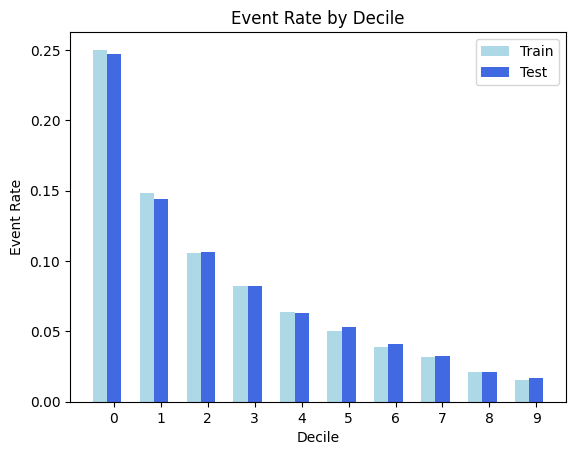

,Metric,Train Value,Test Value
0,KS,0.361074,0.347535
1,AUC,0.740489,0.735727
2,Gini,0.480978,0.471454


In [691]:
metrics, ord_score_train, ord_score_test = calculate_metrics_rl(abt_train_t01, abt_teste_t01, 'Score_1', 'Score_0', 'TARGET', bins=10)
metrics

In [692]:
ord_score_train

,decile,min_score,max_score,event_rate,volume
0,0,0.0776,0.8283,0.250216,15075
1,1,0.8284,0.8817,0.148106,15077
2,2,0.8818,0.9102,0.105883,15111
3,3,0.9103,0.9290,0.082353,15045
4,4,0.9291,0.9428,0.063930,15079
5,5,0.9429,0.9537,0.050358,15092
6,6,0.9538,0.9629,0.038872,15178
7,7,0.9630,0.9712,0.032087,15084
8,8,0.9713,0.9793,0.021039,14877
9,9,0.9794,1.0000,0.015670,15061


In [693]:
ord_score_test

,decile,min_score,max_score,event_rate,volume
0,0,0.2854,0.8279,0.247021,6461
1,1,0.8280,0.8806,0.143829,6466
2,2,0.8807,0.9095,0.106617,6453
3,3,0.9096,0.9282,0.082109,6467
4,4,0.9283,0.9422,0.063360,6471
5,5,0.9423,0.9533,0.053040,6448
6,6,0.9534,0.9626,0.040975,6443
7,7,0.9627,0.9710,0.032759,6502
8,8,0.9711,0.9791,0.021375,6456
9,9,0.9792,1.0000,0.017002,6411


In [694]:
import pickle
with open('../artifacts/modelo_regressao_logistica.pkl', 'wb') as file:
    pickle.dump(model, file)